# Automatically Rename Remote Worker Agents based on the employee's HR profile

This notebook showcases a use-case suitable for anyone managing more than 100 remote worker agents on their BeezKeeper. It actually came out from a request from one of our customers who is managing more than 1000 remote worker agents. They wanted to name the agents with the employee's first name, last name and office number. The remote worker agent software reports the employee's ID, which is the same as the laptop's name, to the NetBeez BeezKeeper server. Then there is a script running on AWS Lambda which periodically checks for new agents whose name matches a regular expression representing the ID format, using the NetBeez API. When it finds some, it cross-references that ID with the employee's profile on the HR software and generates a string with the ID, first name, last name and office number for each agent. It finally submits those names back to the NetBeez server API and they get updated. This diagram represents the workflow:
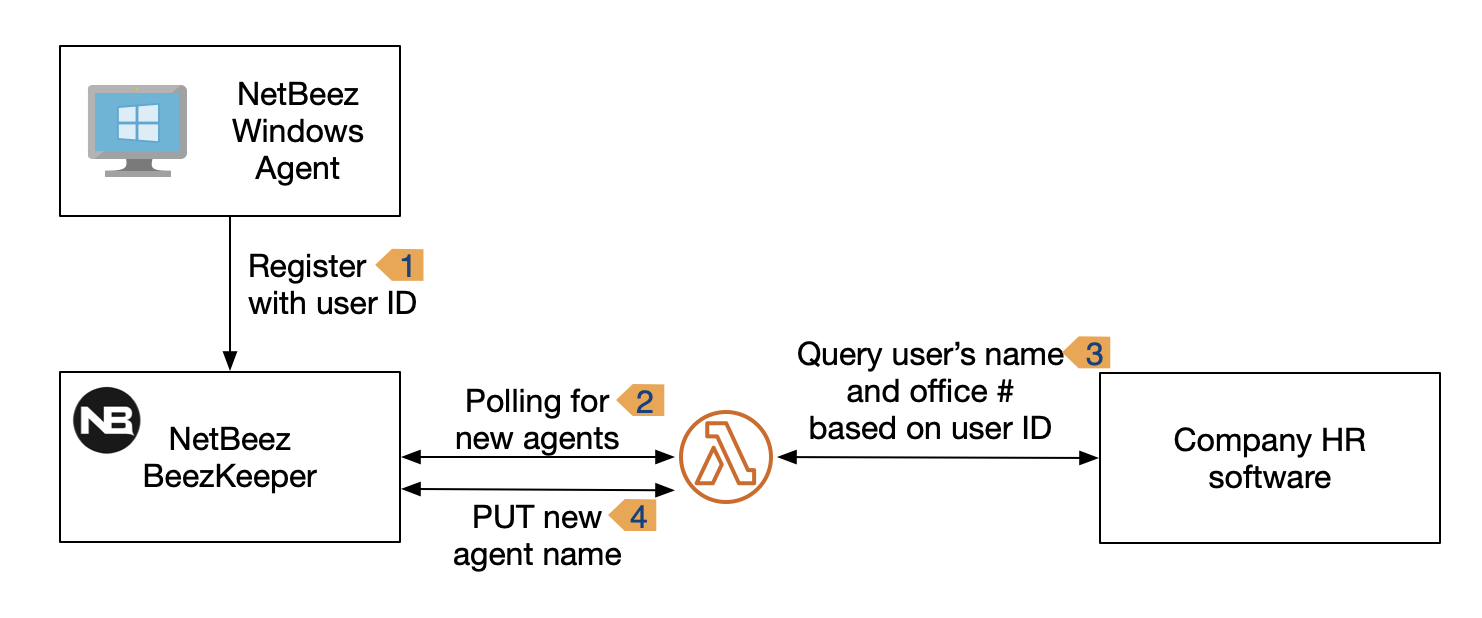

In the following sections we will describe how the python script running in the Lambda function can be written to implement the functionality we just described.

## Setup your script for NetBeez BeezKeeper API access.

The following code will initialize everything needed to enable your script to access the API. If you would like to learn exactly how this setup works, please reffer to [our previous blogpost](https://netbeez.net/blog/netbeez-ping-api-results/) about using the NetBeez API.

In [1]:
beezkeeper_fqdn="demo.netbeezcloud.net"  ## <--------- CHANGE THIS TO YOUR INSTANCE FQDN
base_url='https://' + beezkeeper_fqdn

api_key="7g5_hKXw_460SNKEkJEYlMn1eqw3iTmaus_cCMZ8REhc5MOEtEAx8g"  # <--------- CHANGE THIS TO YOUR KEY

import requests
import urllib3

urllib3.disable_warnings()


nb_headers = {
    'Cache-Control': 'no-store',
    'Content-type': 'application/json',
    'Authorization': 'Bearer ' + api_key
}

## Function to get the agents records
In this section we implement the function that will get the agents which only have the employee ID in their name.

The format of the employee id is `id1234567` so a regular expression that matches names which  have the ID at the end of it would be `id[0-9]{7}$`

In [2]:
def getNBAgents():
    payload = ''
    url = base_url + '/agents?filter[name][regex]=id[0-9]{7}$&stubbed=true&page[offset]=1&page[limit]=1000&type=beta'
    response = requests.request("GET", url, headers=nb_headers, verify=False)
    return response.json()['data']


print(getNBAgents())

[{'id': '363', 'type': 'agent_stub', 'attributes': {'description': None, 'agent_class': 'mac', 'active': False, 'category': 'remote_worker_agent', 'agent_type_name': 'mac', 'open_incident_id': None, 'reached_target_test_limit': False, 'reached_scheduled_test_limit': False, 'name': 'id5647382'}}]


## Function to get the employee information

In this section we implement the HR database lookup. For the sake of demonstration we'll just use a public API that is generating random names. When you are implementing this workflow you should check the software's documentation for information on how to get employee names from your HR software.

In [3]:
def getEmployeeName(employee_id):
    url = 'https://namey.muffinlabs.com/name.json?count=1&with_surname=true&frequency=common&employee_id=' + employee_id
    response = requests.get(url)
    return response.json()[0]

print(getEmployeeName('id1234567'))

Sandra Wallace


## Function to generate an array of objects containing agent ids and employee names

We now implement the function that generates an array of objects with agent ids and names that will be used as the data pushed back to the NetBeez server to update the agent record names.

In [4]:
def generatePayloadFromAgents(agents):
    agentsToUpdate = []
    for agent in agents:
        employeeName = getEmployeeName(agent['attributes']['name'])
        agentId = int(agent['id'])
        newAgentName = agent['attributes']['name'] + ' - ' + employeeName
        agentsToUpdate.append({ 'id': agentId, 'name': newAgentName})
    payload = { 'agents': agentsToUpdate }
    return payload

print(generatePayloadFromAgents(getNBAgents()))

{'agents': [{'id': 363, 'name': 'id5647382 - John Johnson'}]}


## Function to push the new agent names back to the NetBeez API

Now that we have all the data transformation function done, we can implement the final step which is the PUT request back to the NetBeez API, which takes as input the output from the `generatePayloadFromAgents()` function.

In [5]:
def pushNBAgentsWithEmployeeNames(newAgentNamesPayload):
    url = base_url + '/agents?type=beta'
    response = requests.request('PUT', url, headers=nb_headers, data=json.dumps(newAgentNamesPayload))
    return response
